# JKL Temperature Analysis

## Exploring Digital Elevation Model (DEM) and ERA5 Climate Data

### Region Focus: Jammu, Kashmir, and Ladakh (JKL)

#### Author: [Hamid Ali Syed](https://syedha.com)

---

**Objective**: Learning something new

---

In [1]:
import os
import requests
import rasterio
import numpy as np
import pandas as pd
import xarray as xr
from osgeo import gdal
import geopandas as gpd
import rioxarray as rio
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from rasterio.features import geometry_mask

# ---This is for decorating the figure with the cartopy functions ---
# ---Uncomment the below three lines and run it only once ---
import urllib.request
url = "https://raw.githubusercontent.com/syedhamidali/test_scripts/master/map_features.py"
urllib.request.urlretrieve(url, "map_features.py")
import map_features as mf
# --- END of the section --- 

ModuleNotFoundError: No module named 'rasterio'

## Custom defining plotting parameters

In [2]:
plt.rcParams['axes.labelsize']= 14
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['legend.fontsize']= 14
plt.rcParams['font.size']=14
plt.rcParams['xtick.direction']='in'
plt.rcParams['xtick.major.size']= 5
plt.rcParams['xtick.major.width']= 1
plt.rcParams['xtick.minor.size']= 1.5
plt.rcParams['xtick.minor.width']= 1
plt.rcParams['ytick.direction']='in'
plt.rcParams['ytick.major.size']= 5
plt.rcParams['ytick.major.width']= 1
plt.rcParams['ytick.minor.size']= 1.5
plt.rcParams['ytick.minor.width']= 1
plt.rcParams['axes.linewidth']= 0.8
plt.rcParams['grid.linewidth']= 0.8
plt.rcParams['font.style'] = "normal"
plt.rcParams['font.weight'] = "bold"

## Important functions

Below given functions are needed to download the SRTM data, here we are only defining these, but will apply as we move ahead

In [2]:
def init_header_redirect_session(token=None):
    token = os.environ.get("EARTHDATA_BEARER_TOKEN", token)
    if token is None:
        raise ValueError("EARTHDATA_BEARER_TOKEN environment variable missing.")
    session = requests.Session()
    session.headers.update({"Authorization": f"Bearer {token}"})
    return session

def download_srtm(filename, destination, resolution=3, session=None):
    website = "https://e4ftl01.cr.usgs.gov/MEASURES"
    subres = '2' if resolution == 30 else '3'
    resolution = f"SRTMGL{resolution}.00{subres}"
    source = f"{website}/{resolution}/2000.02.11"
    url = f"{source}/{filename}"
    session = session or init_header_redirect_session()
    with session.get(url, stream=True, timeout=5) as r:
        r.raise_for_status()
        with open(destination or filename, "wb") as fd:
            for chunk in r.iter_content(chunk_size=1024*1014):
                fd.write(chunk)
    return r.status_code

def get_srtm_tile_names(extent):
    lonmin, lonmax, latmin, latmax = [int(np.floor(x)) for x in extent]
    return [f"{'N' if lat >= 0 else 'S'}{abs(lat):02d}{'E' if lon >= 0 else 'W'}{abs(lon):03d}" 
            for lat in range(latmin, latmax + 1) for lon in range(lonmin, lonmax + 1)]

def get_srtm(extent, resolution=3, merge=True, session=None, filename=""):
    filelist = [f"{f}.SRTMGL{resolution}.hgt.zip" for f in get_srtm_tile_names(extent)]
    dem_path = os.path.join("demler_data", "geo")
    os.makedirs(dem_path, exist_ok=True)
    demlist = []
    session = session or init_header_redirect_session()
    for filename in filelist:
        path = os.path.join(dem_path, filename)
        if not os.path.exists(path):
            download_srtm(filename, path, resolution=resolution, session=session)
        if os.path.exists(path):
            demlist.append(gdal.Open(path))
    if not merge:
        return demlist
    output_filename = 'merged_dem.tif'
    dem = gdal.Warp(output_filename, demlist, format="GTiff")
    xds = rio.open_rasterio(output_filename)
    # Since it is very high resolution data, we can coarsen it to match
    # a little bit for now to save some space
    xds = xds.coarsen(x=12, y=12, boundary='trim').mean()
    xds.rio.to_raster(output_filename)
    return xds

## Download DEM
Setting environment for downloading DEM data, you have to generate a token (only once) in order to download the SRTM data at this website https://urs.earthdata.nasa.gov/

### Setup environment

In [4]:
from earth_data_token import token

Remember to create your account and paste the token here. 
 Get token from https://urs.earthdata.nasa.gov/


In [5]:
os.environ["EARTHDATA_BEARER_TOKEN"] = token
# os.environ["EARTHDATA_BEARER_TOKEN"] = 'paste token here and uncomment this line and run it'

### Download SRTM
- We are using `get_srtm` function that takes the argument `extent` as a list, you have to provide 4 points, i.e., lonmin, lonmax, latmin, and latmax.
- It will save the file as a tif format, we will use xarray based python package called rioxarray to read the data

In [6]:
# Define the extent [lonmin, lonmax, latmin, latmax]
extent = [72, 80, 30, 37]  # Example extent
# Call get_srtm with the extent, resolution, and merge option
# Example uses a resolution of 3 and merges tiles
dataset = get_srtm(extent, resolution=3, merge=True)

/Users/syed44/miniconda3/envs/radar/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Now that we have downloaded the file, we can read that using `rioxarray`

In [3]:
xds = rio.open_rasterio('merged_dem.tif')
# Since it is very high resolution data, we can coarsen it to match
# it with the ERA5 0.1 x 0.1 resolution data.
# xds_cs = xds.coarsen(x=12, y=12, boundary='trim').mean()

## Download JK shape files
Uncomment the below cell, and run it only once to download the shape files

In [4]:
# !git clone https://github.com/syedhamidali/India-Shapefiles.git

### Read shape files

<Axes: >

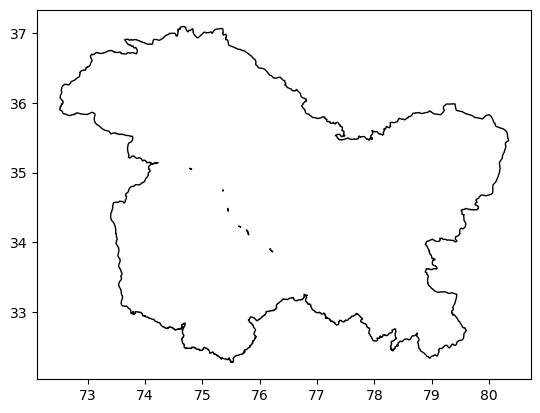

In [5]:
# Load GeoDataFrame
gdf = gpd.read_file('India-Shapefiles/India States Boundary/')
# Specify states to combine
states_to_combine = ['Ladakh', 'Jammu and Kashmir']
# Filter for the states to combine
jkl = gdf[gdf['Name'].isin(states_to_combine)]
# Combine the geometries into a single geometry
combined_geometry = jkl.geometry.unary_union
# Create a new GeoDataFrame for the combined geometry
combined_jkl = gpd.GeoDataFrame([{'Name': 'JKL', 'geometry': combined_geometry}],
                                crs=jkl.crs)  # Ensure the CRS is consistent
combined_jkl.plot(ec='k', fc='none')

## Clip DEM with the Shape file

We will mask all the raster data or DEM data using outside the JK boundary using these shape files. This is important for bringing all datsets to the same level

In [6]:
xds.rio.write_crs(combined_jkl.crs, inplace=True)
# Clip xds_cs using the combined_jkl boundary
xds_clipped = xds.rio.clip(combined_jkl.geometry, combined_jkl.crs, drop=True, invert=False)

In [7]:
xds_above_zero = xds_clipped[0].where(xds_clipped[0]>0)

In [8]:
xds_cs = xds_above_zero.coarsen(x=10, y=10, boundary='trim').mean()
xds_cs

<xarray.DataArray (y: 48, x: 78)> Size: 30kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int64 8B 1
  * x            (x) float64 624B 72.56 72.66 72.76 72.86 ... 80.06 80.16 80.26
  * y            (y) float64 384B 37.05 36.95 36.85 36.75 ... 32.55 32.45 32.35
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    units:          m
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -32768.0

## Plot DEM

Let's see what we have got so far

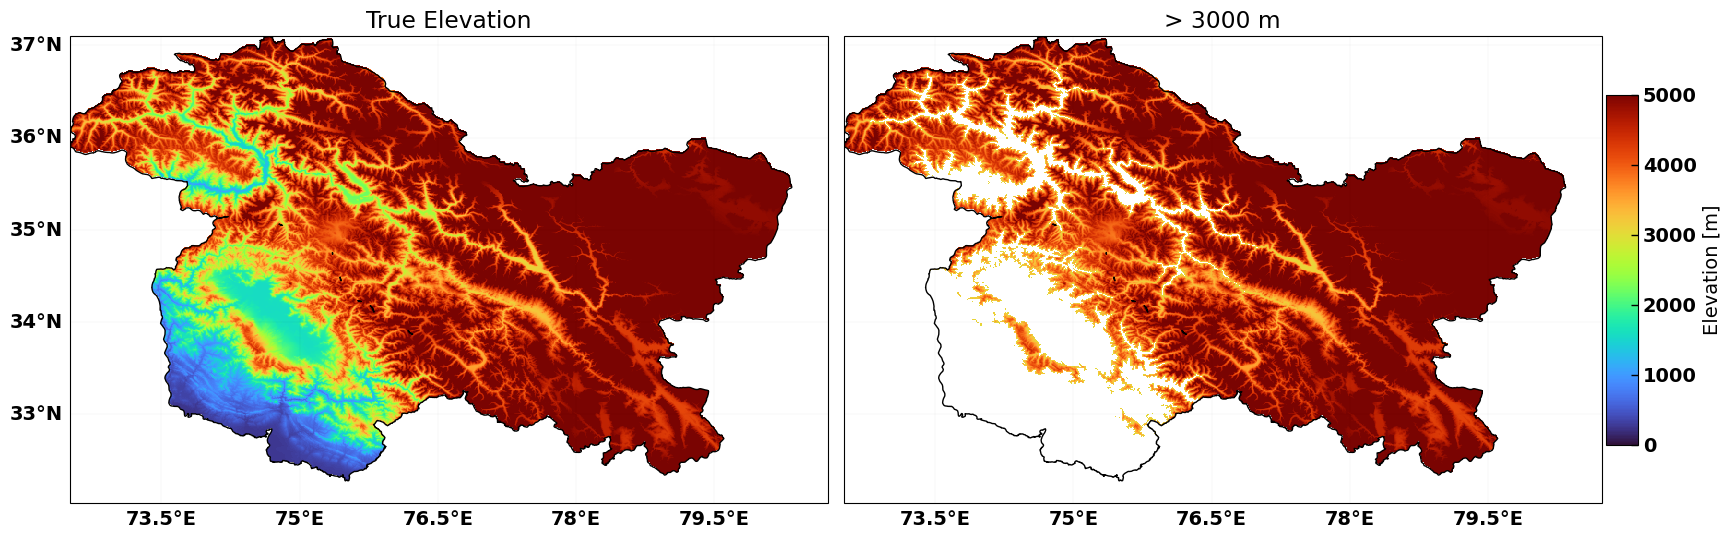

In [13]:
fig = plt.figure(figsize=[16, 7], constrained_layout=True)
ax = plt.subplot(121, projection=ccrs.PlateCarree())
img = xds_above_zero.plot.imshow(cmap='turbo', vmin=0, vmax=5000, ax=ax, add_colorbar=False)
mf.map_features(ax, b=True, l=True, states=False)
ax.set_title("True Elevation")
combined_jkl.plot(ax=ax, ec='k', fc='none')
ax.set_aspect('equal')

ax = plt.subplot(122, projection=ccrs.PlateCarree())
xds_above_zero.where(xds_above_zero>3000).plot.imshow(cmap='turbo',
                                                      vmin=0, vmax=5000, ax=ax, add_colorbar=False)
combined_jkl.plot(ax=ax, ec='k', fc='none')
mf.map_features(ax, b=1, l=0, states=False,)
ax.set_title("> 3000 m")
ax.set_aspect('equal')

cbar_ax = fig.add_axes([1, 0.25, 0.02, 0.5],) #lbwh
cbar1 = fig.colorbar(img, cax=cbar_ax,orientation='vertical')
cbar1.set_label('Elevation [m]')

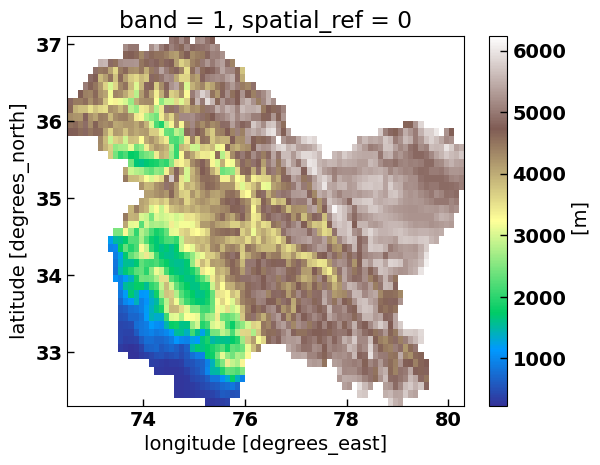

In [14]:
xds_cs.plot(cmap='terrain') # remember this xds_cs dataset, we'll use it for the main analysis

## Download ERA5 data

I'll use the python API to download the reanalysis-era5-land-monthly-means data, but you are welcome to use whatever data you like, and however you wish to download that.
- Uncomment the below code to download the temperature data from ERA5

In [15]:
# import cdsapi

# c = cdsapi.Client()

# c.retrieve(
#     'reanalysis-era5-land-monthly-means',
#     {
#         'product_type': 'monthly_averaged_reanalysis',
#         'variable': '2m_temperature',
#         'year': '2023',
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#         ],
#         'time': '00:00',
#         'area': [
#             45, 70, 30,
#             85,
#         ],
#         'format': 'grib',
#     },
#     'ERA_JK.grib')

## Read ERA5 Data
I'll use temperature data in this study. We have to make the data identical to `xds_cs`.

In [16]:
ds = xr.open_dataset('ERA_JK.grib', engine='cfgrib')
ds.rio.write_crs(combined_jkl.crs, inplace=True)
# Clip xds_cs using the combined_jkl boundary
ds_clipped = ds.rio.clip(combined_jkl.geometry, combined_jkl.crs, drop=True, invert=False)

/Users/syed44/miniconda3/envs/radar/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
Struct() takes at most 1 argument (3 given)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
Ignoring index file 'ERA_JK.grib.923a8.idx' older than GRIB file


0.3.0


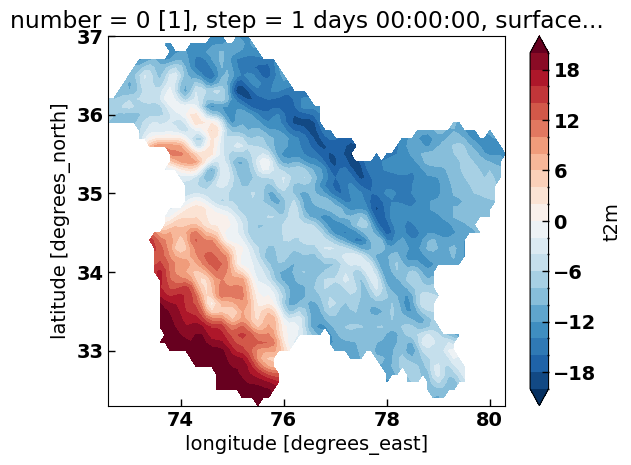

In [17]:
(ds_clipped['t2m']-273.15).mean('time').plot.contourf(levels=np.arange(-20, 20.1, 2))

## Analysis

In [18]:
# Let's confirm if the shape of the dataset is same
print(ds_clipped['t2m'][0].shape) # [0] is for the first timestamp, 48 lats, & 78 lons, Temp. data
print(xds_cs.shape) # DEM data

(48, 78)
(48, 78)


In [19]:
xds_cs = xds_cs.rename({'y':'latitude',
                        'x':'longitude'}
                      )
xds_cs = xds_cs.drop_vars(['spatial_ref', 'band'])

In [20]:
xds_cs

<xarray.DataArray (latitude: 48, longitude: 78)> Size: 30kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 624B 72.56 72.66 72.76 ... 80.06 80.16 80.26
  * latitude   (latitude) float64 384B 37.05 36.95 36.85 ... 32.55 32.45 32.35
Attributes:
    AREA_OR_POINT:  Point
    units:          m
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -32768.0

In [21]:
ds_clipped = ds_clipped.drop_vars(['number',
                                   'step',
                                   'surface',
                                   'spatial_ref',
                                   'valid_time'])

In [22]:
temp = (ds_clipped['t2m']-273.15).mean('time')

In [23]:
print(temp)

<xarray.DataArray 't2m' (latitude: 48, longitude: 78)> Size: 15kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 384B 37.0 36.9 36.8 36.7 ... 32.5 32.4 32.3
  * longitude  (longitude) float64 624B 72.6 72.7 72.8 72.9 ... 80.1 80.2 80.3


In [24]:
print(xds_cs)

<xarray.DataArray (latitude: 48, longitude: 78)> Size: 30kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 624B 72.56 72.66 72.76 ... 80.06 80.16 80.26
  * latitude   (latitude) float64 384B 37.05 36.95 36.85 ... 32.55 32.45 32.35
Attributes:
    AREA_OR_POINT:  Point
    units:          m
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -32768.0


## Define the New Common Grid

In [25]:
# Define the new common grid
new_latitudes = np.arange(start=min(temp.latitude.min(), xds_cs.latitude.min()), 
                          stop=max(temp.latitude.max(), xds_cs.latitude.max()), 
                          step=0.1)  # Example step, adjust as needed

new_longitudes = np.arange(start=min(temp.longitude.min(), xds_cs.longitude.min()), 
                           stop=max(temp.longitude.max(), xds_cs.longitude.max()), 
                           step=0.1)  # Example step, adjust as needed

## Interpolate Both Datasets to the New Grid

In [26]:
# Interpolate temp to the new grid
temp_interpolated = temp.interp(latitude=new_latitudes, longitude=new_longitudes, method='linear')

# Interpolate xds_cs to the new grid
xds_cs_interpolated = xds_cs.interp(latitude=new_latitudes, longitude=new_longitudes, method='linear')

## Apply the Mask and Plot

After interpolating both datasets to the same grid, you can then apply the mask (where xds_cs_interpolated is greater than 3000 meters) to the temp_interpolated dataset and plot the result.

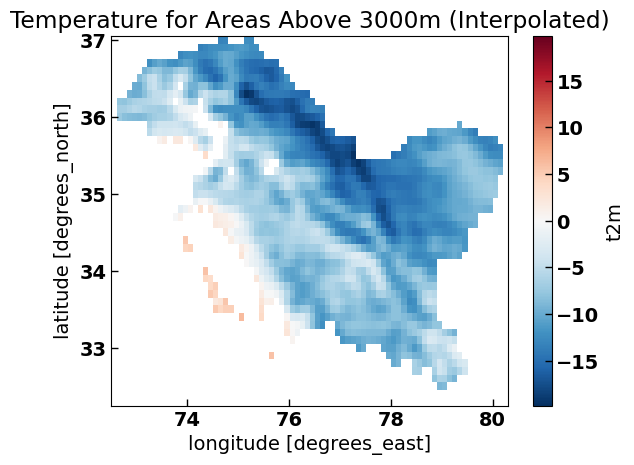

In [27]:
# Create the mask based on the interpolated xds_cs
mask = xds_cs_interpolated > 3000

# Apply the mask to the interpolated temp DataArray
temp_masked = temp_interpolated.where(mask)
temp_masked.plot()
plt.title('Temperature for Areas Above 3000m (Interpolated)')
plt.show()

## Plot Comparison

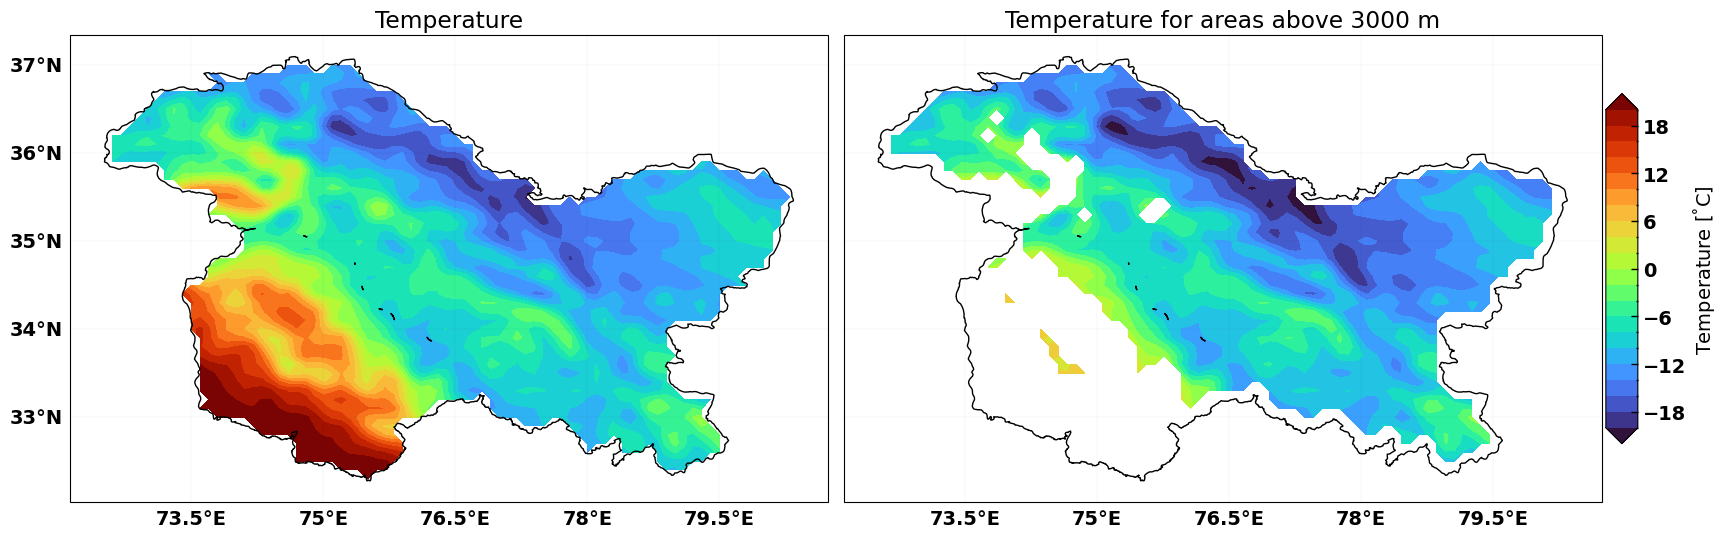

In [28]:
fig = plt.figure(figsize=[16, 7], constrained_layout=True)
ax = plt.subplot(121, projection=ccrs.PlateCarree())
img = temp.plot.contourf(cmap='turbo', ax=ax, add_colorbar=False, levels=np.arange(-20, 20.1, 2))
mf.map_features(ax, b=True, l=True, states=False)
ax.set_title("Temperature")
combined_jkl.plot(ax=ax, ec='k', fc='none')
ax.set_aspect('equal')

ax = plt.subplot(122, projection=ccrs.PlateCarree())
temp_masked.plot.contourf(cmap='turbo', ax=ax, add_colorbar=False, levels=np.arange(-20, 20.1, 2))
combined_jkl.plot(ax=ax, ec='k', fc='none')
mf.map_features(ax, b=1, l=0, states=False,)
ax.set_title("Temperature for areas above 3000 m")
ax.set_aspect('equal')

cbar_ax = fig.add_axes([1, 0.25, 0.02, 0.5],) #lbwh
cbar1 = fig.colorbar(img, cax=cbar_ax,orientation='vertical')
cbar1.set_label(r'Temperature [$^\degree$C]')

## Make Logo
Let's create logo for Jupyter Book to publish it to web

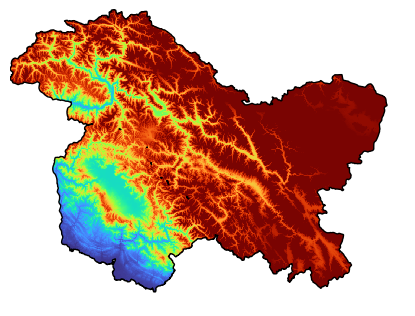

In [27]:
fig = plt.figure(figsize=[8, 7], constrained_layout=True)
ax = plt.subplot(121, projection=ccrs.PlateCarree())
img = xds_above_zero.plot.imshow(cmap='turbo', vmin=0, vmax=5000, ax=ax, add_colorbar=False)
# mf.map_features(ax, b=True, l=True, states=False, grids=False)
ax.set_title("")
combined_jkl.plot(ax=ax, ec='k', fc='none')
ax.axis('off')
# plt.savefig("logo.png", dpi=60, bbox_inches='tight')
plt.show()

Thank you for your attention. Feel free to reach out in case you have any doubts.